In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/onlineretail1/online_retail.xlsx


############################################
# KPI & COHORT ANALYSIS: RETENTION RATE
############################################

# RETENTION RATE'S KPI COHORT ANALYSIS IN 3 STEPS


# 1. Data Preprocessing
# 2. Creating retention matrix
#    1. Calculating unique orders for every customer
#    2. Number of customers who have placed orders more than once in the entire dataset
#    3. Catching order months
#    4. Generating of cohort variable
#    5. Extracting number of customers per month
#    6. Extracting period number
#    7. Generating cohort_pivot
#    8. Generating Retention_matrix
# 3.Visualization of retention matrix with heatmap

In [2]:
####################################
# 1. Data Preprocessing
####################################



import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 10)
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from operator import attrgetter
import matplotlib.colors as mcolors
!pip install xlrd
!pip install openpyxl

     |████████████████████████████████| 96 kB 370 kB/s 
     |████████████████████████████████| 243 kB 412 kB/s 
  Created wheel for et-xmlfile: filename=et_xmlfile-1.0.1-py3-none-any.whl size=8913 sha256=235ad7c5accb4bc0107d19dfebb2fd35742be7662628e41ec7cf38b2769d7b29
  Stored in directory: /root/.cache/pip/wheels/e2/bd/55/048b4fd505716c4c298f42ee02dffd9496bb6d212b266c7f31
Successfully built et-xmlfile


In [3]:
df_ = pd.read_excel('../input/onlineretail1/online_retail.xlsx',
                   dtype={'CustomerID': str,
                          'InvoiceID': str},
                   parse_dates=['InvoiceDate'])

In [4]:
df=df_.copy()

In [5]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [6]:
df.shape

(541909, 8)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


In [8]:
df.dropna(subset=["CustomerID"],inplace=True)

In [9]:
df=df[["CustomerID","InvoiceNo","InvoiceDate"]].drop_duplicates()

In [10]:
df.shape

(22221, 3)

In [11]:
####################################
# 2. Creating retention matrix
####################################

In [12]:
#1. Calculating unique orders for every customer
n_orders = df.groupby(['CustomerID'])['InvoiceNo'].nunique()

In [13]:
#2.Number of customers who have placed orders more than once in the entire dataset
orders_perc=np.sum(n_orders>1)/df["CustomerID"].nunique()
100*orders_perc

69.967978042086

In [14]:
# 3. Catching order months
df["order_month"]=df["InvoiceDate"].dt.to_period("M")

In [15]:
#4.Generating of cohort variable
df["cohort"]=df.groupby("CustomerID")["InvoiceDate"].transform("min").dt.to_period("M")

In [16]:
#5.Extracting number of customers per month
df_cohort=df.groupby(["cohort","order_month"]).agg(n_customers=("CustomerID","nunique")).reset_index(drop=False)

In [17]:
#6.Extracting period number
(df_cohort.order_month-df_cohort.cohort).head()

0    <0 * MonthEnds>
1         <MonthEnd>
2    <2 * MonthEnds>
3    <3 * MonthEnds>
4    <4 * MonthEnds>
dtype: object

In [18]:
df_cohort["period_number"]=(df_cohort.order_month-df_cohort.cohort).apply(attrgetter("n"))

In [19]:
#7. generating cohort_pivot
cohort_pivot=df_cohort.pivot_table(index="cohort",columns="period_number",values="n_customers")

In [20]:
cohort_size=cohort_pivot.iloc[:,0]

In [21]:
#8.generating retention_matrix
retention_matrix=cohort_pivot.divide(cohort_size,axis=0)

In [22]:
retention_matrix

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2010-12,1.0,0.381857,0.334388,0.387131,0.359705,0.396624,0.379747,0.354430,0.354430,0.394515,0.373418,0.500000,0.274262
2011-01,1.0,0.239905,0.282660,0.242280,0.327791,0.299287,0.261283,0.256532,0.311164,0.346793,0.368171,0.149644,NaN
2011-02,1.0,0.247368,0.192105,0.278947,0.268421,0.247368,0.255263,0.281579,0.257895,0.313158,0.092105,NaN,NaN
2011-03,1.0,0.190909,0.254545,0.218182,0.231818,0.177273,0.263636,0.238636,0.288636,0.088636,NaN,NaN,NaN
2011-04,1.0,0.227425,0.220736,0.210702,0.207358,0.237458,0.230769,0.260870,0.083612,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-08,1.0,0.251497,0.251497,0.251497,0.137725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-09,1.0,0.298658,0.325503,0.120805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-10,1.0,0.264205,0.130682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
def create_retention_matrix(dataframe):
    n_orders = dataframe.groupby(['CustomerID'])['InvoiceNo'].nunique()
    dataframe['order_month'] = dataframe['InvoiceDate'].dt.to_period('M')
    dataframe['cohort'] = dataframe.groupby('CustomerID')['InvoiceDate'] \
        .transform('min') \
        .dt.to_period('M')
    df_cohort = dataframe.groupby(['cohort', 'order_month']) \
        .agg(n_customers=('CustomerID', 'nunique')) \
        .reset_index(drop=False)
    df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))
    cohort_pivot = df_cohort.pivot_table(index='cohort',
                                         columns='period_number',
                                         values='n_customers')

    cohort_size = cohort_pivot.iloc[:, 0]
    retention_matrix = cohort_pivot.divide(cohort_size, axis=0)
    return retention_matrix


In [24]:
create_retention_matrix(df)

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2010-12,1.0,0.381857,0.334388,0.387131,0.359705,0.396624,0.379747,0.354430,0.354430,0.394515,0.373418,0.500000,0.274262
2011-01,1.0,0.239905,0.282660,0.242280,0.327791,0.299287,0.261283,0.256532,0.311164,0.346793,0.368171,0.149644,NaN
2011-02,1.0,0.247368,0.192105,0.278947,0.268421,0.247368,0.255263,0.281579,0.257895,0.313158,0.092105,NaN,NaN
2011-03,1.0,0.190909,0.254545,0.218182,0.231818,0.177273,0.263636,0.238636,0.288636,0.088636,NaN,NaN,NaN
2011-04,1.0,0.227425,0.220736,0.210702,0.207358,0.237458,0.230769,0.260870,0.083612,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-08,1.0,0.251497,0.251497,0.251497,0.137725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-09,1.0,0.298658,0.325503,0.120805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-10,1.0,0.264205,0.130682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
####################################
# 3. Visualization of retention matrix with heatmap
####################################

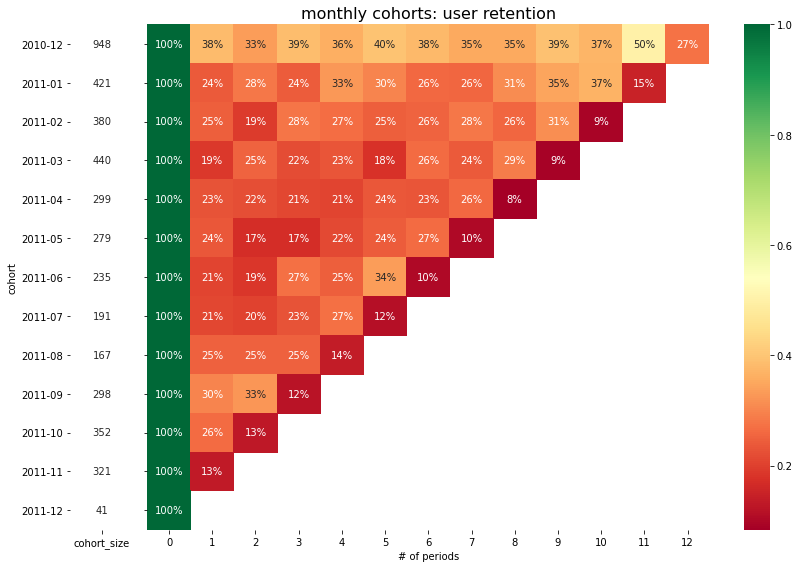

In [26]:
import seaborn as sns 
sns.axes_style("white")
fig,ax=plt.subplots(1,2,figsize=(12,8),sharey=True,
                   gridspec_kw={"width_ratios":[1,11]}
                    #to create the grid the subplots are placed on
                   )
#retention matrix
sns.heatmap(retention_matrix,annot=True,fmt=".0%" #showing on percentage of expressions
            ,cmap="RdYlGn",ax=ax[1])
ax[1].set_title("monthly cohorts: user retention",fontsize=16)
ax[1].set(xlabel="# of periods",ylabel="")
# cohort size
cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
white_cmap = mcolors.ListedColormap(['white'])
sns.heatmap(cohort_size_df,
            annot=True,
            cbar=False,  # we dont want cbar for second plot (right side colorful scaling)
            fmt='g',
            cmap=white_cmap,
            ax=ax[0])
fig.tight_layout()
plt.show()